# **Training an Testing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [2]:
def load_data_files():

    base_dir = os.path.abspath(os.path.dirname(__file__)) if '__file__' in globals() else os.getcwd()

    data_dir = os.path.join(base_dir, 'Processed Data')

    X_train_path = os.path.join(data_dir, 'X_train_processed.npy')
    y_train_path = os.path.join(data_dir, 'y_train_processed.npy')
    X_test_path = os.path.join(data_dir, 'X_test_processed.npy')
    y_test_path = os.path.join(data_dir, 'y_test_processed.npy')

    X_train_mx = np.load(X_train_path, allow_pickle = True).item()
    y_train_mx = np.load(y_train_path, allow_pickle = True)
    X_test_mx = np.load(X_test_path, allow_pickle = True).item()
    y_test_mx = np.load(y_test_path, allow_pickle = True)

    X_train = pd.DataFrame(X_train_mx.toarray())
    y_train = pd.Series(y_train_mx.ravel())
    X_test = pd.DataFrame(X_test_mx.toarray())
    y_test = pd.Series(y_test_mx.ravel())

    return X_train, y_train, X_test, y_test

In [3]:
# Call the function

X_train, y_train, X_test, y_test = load_data_files()

In [4]:
def load_column_names():

    base_dir = os.path.abspath(os.path.dirname(__file__)) if '__file__' in globals() else os.getcwd()

    data_dir = os.path.join(base_dir, 'Processing Objects')

    column_names_path = os.path.join(data_dir, 'the_preprocessor.joblib')

    column_names_pre = joblib.load(column_names_path)

    column_names = column_names_pre.get_feature_names_out()

    return column_names

In [5]:
# Call the function

column_names = load_column_names()

In [6]:
# Match the name with the corresponding column

X_train.columns = column_names
X_test.columns = column_names

In [7]:
print(column_names.tolist())

['numerical__Age', 'numerical__EducationLevel', 'numerical__BMI', 'numerical__CognitiveTestScore', 'binary_categorical__Gender_Male', 'binary_categorical__Diabetes_Yes', 'binary_categorical__Hypertension_Yes', 'binary_categorical__CholesterolLevel_Normal', 'binary_categorical__AlzheimerInFamily_Yes', 'binary_categorical__GeneticRisk_Yes', 'binary_categorical__UrbanRural_Urban', 'multi_binary_categorical__Country_Argentina', 'multi_binary_categorical__Country_Australia', 'multi_binary_categorical__Country_Brazil', 'multi_binary_categorical__Country_Canada', 'multi_binary_categorical__Country_China', 'multi_binary_categorical__Country_France', 'multi_binary_categorical__Country_Germany', 'multi_binary_categorical__Country_India', 'multi_binary_categorical__Country_Italy', 'multi_binary_categorical__Country_Japan', 'multi_binary_categorical__Country_Mexico', 'multi_binary_categorical__Country_Norway', 'multi_binary_categorical__Country_Russia', 'multi_binary_categorical__Country_Saudi Ara

# **Hyperparameter Tuning**

In [8]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

c:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Stratified Cross Validation

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [10]:
# Dictionary to save the results

model_results = {}

In [11]:
# Hyperparameter Tuning with Optuna (Objective Functions)



# XGBoost

# Personalized Wrapping, to ensure that XGBoost Classifier behaves like a Sklearn method

from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier

class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, **kwargs):

        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y):

        self.model.fit(X, y)

        return self

    def predict(self, X):
        
        return self.model.predict(X)

    def predict_proba(self, X):
        
        return self.model.predict_proba(X)

    def get_params(self, deep = True):
        
        return self.model.get_params(deep)

    def set_params(self, **params):
        
        self.model.set_params(**params)
        
        return self



def xgb_objective(trial):
    
    model = SklearnXGBClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 150),
        max_depth = trial.suggest_int('max_depth', 5, 15),
        learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1, log = True),
        subsample = trial.suggest_float('subsample', 0.5, 1.0),
        eval_metric = 'logloss',random_state = 42,n_jobs = -1
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()



# Stacking

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

def stacking_objective(trial):

    estimators = [
        ('rf', RandomForestClassifier(n_estimators = 50, random_state = 42)),
        ('dt', DecisionTreeClassifier(min_samples_leaf = 2, random_state = 42)),
        ('gbc', GradientBoostingClassifier(n_estimators = 50, random_state = 42))
    ]

    meta_estimator = LogisticRegression(
        C = trial.suggest_float('C', 1e-2, 10.0, log = True),
        max_iter = 1000,
        random_state = 42
    )

    model = StackingClassifier(
        estimators = estimators,
        final_estimator = meta_estimator,
        passthrough = trial.suggest_categorical('passthrough', [True, False]),
        n_jobs = -1
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()



# Random Forest

from sklearn.ensemble import RandomForestClassifier

def rf_objective(trial):

    model = RandomForestClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 100),
        max_depth = trial.suggest_int('max_depth', 15, 50),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10),
        random_state = 42, n_jobs = -1
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


# LightGBM

from lightgbm import LGBMClassifier

def lgbm_objective(trial):
    
    model = LGBMClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 150),
        max_depth = trial.suggest_int('max_depth', 3, 15),
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log = True),
        num_leaves = trial.suggest_int('num_leaves', 20, 100),
        subsample = trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0),
        random_state = 42, n_jobs=-1, verbosity = -1
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()



# KNN

from sklearn.neighbors import KNeighborsClassifier

def knn_objective(trial):

    model = KNeighborsClassifier(
        n_neighbors = trial.suggest_int('n_neighbors', 3, 8),
        metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


# Decision Tree

from sklearn.tree import DecisionTreeClassifier

def dt_objective(trial):

    model = DecisionTreeClassifier(
        max_depth = trial.suggest_int('max_depth', 3, 12),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 7),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 7),
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']), 
        random_state = 42
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


# Multi-Layer Perceptron

from sklearn.neural_network import MLPClassifier

def mlp_objective(trial):

    model = MLPClassifier(
        hidden_layer_sizes = (trial.suggest_int('hl1', 10, 40),
                              trial.suggest_int('hl2', 10, 50)),
        activation = trial.suggest_categorical('activation', ['relu', 'tanh']),
        alpha = trial.suggest_float('alpha', 1e-3, 1e-1, log = True),
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
        learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log = True),
        max_iter = 500, random_state = 42
        
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


# Gradient Boost Classifier

from sklearn.ensemble import GradientBoostingClassifier

def gbc_objective(trial):
    
    model = GradientBoostingClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 150),
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log = True),
        max_depth = trial.suggest_int('max_depth', 3, 10),
        subsample = trial.suggest_float('subsample', 0.5, 1.0),
        random_state = 42
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()



# Support Vector Machine (SVM)

from sklearn.svm import SVC

def svm_objective(trial):

    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
    gamma = trial.suggest_float('gamma', 1e-3, 1e-1, log = True)
    model = SVC(kernel = kernel, gamma = gamma)

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


In [12]:
# Execute the tuning and save the models as tuples

models = {
    'LightGBM': (lgbm_objective, LGBMClassifier),
    'XGBoost': (xgb_objective, XGBClassifier),
    'Stacking': (stacking_objective, StackingClassifier),
    'Random Forest': (rf_objective, RandomForestClassifier),
    'KNN': (knn_objective, KNeighborsClassifier),
    'Decision Tree': (dt_objective, DecisionTreeClassifier),
    'MLP': (mlp_objective, MLPClassifier),
    'Gradient Boosting': (gbc_objective, GradientBoostingClassifier),
    'SVM': (svm_objective, SVC),
}


for name, (objective, constructor) in models.items():

    print("Optimizating", name, " ...")
    print("------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------")

    study = optuna.create_study(direction = 'maximize')
    study.optimize(objective, n_trials = 10)

    print("Best accuracy: ", study.best_value)
    print("Hyperparameters: ", study.best_params)

    
    # Train the model with the best hyperparameter fit

    if name == 'MLP':
        params = study.best_params.copy()
        hl1 = params.pop('hl1')
        hl2 = params.pop('hl2')
        final_model = constructor(
            hidden_layer_sizes = (hl1, hl2),
            **params
        )

    elif name == 'Stacking':
        params = study.best_params.copy()
        passthrough = params.pop('passthrough')
        C = params.pop('C')

        estimators = [
            ('rf', RandomForestClassifier(n_estimators = 50, random_state = 42)),
            ('dt', DecisionTreeClassifier(min_samples_leaf = 2, random_state = 42)),
            ('gbc', GradientBoostingClassifier(n_estimators = 50, random_state = 42))
        ]

        final_model = StackingClassifier(
            estimators = estimators,
            final_estimator = LogisticRegression(C = C, max_iter = 1000, random_state = 42),
            passthrough = passthrough, n_jobs = -1
        )

    else:
        final_model = constructor(**study.best_params)


    # Fit the model

    final_model.fit(X_train, y_train)

    # Evaluate on test set

    y_pred = final_model.predict(X_test)
    acc_metric = accuracy_score(y_test, y_pred)

    print("Accuracy in test: ", acc_metric)

    # Save results

    model_results[name] = {
        'accuracy_test': acc_metric,
        'model': final_model,
        'parameters': study.best_params,
        'study': study
    }

[I 2025-06-24 12:25:42,708] A new study created in memory with name: no-name-b851720e-23a9-4287-9db3-4a625c784612


Optimizating LightGBM  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-24 12:25:43,892] Trial 0 finished with value: 0.6583329702560158 and parameters: {'n_estimators': 72, 'max_depth': 12, 'learning_rate': 0.006981508097440019, 'num_leaves': 46, 'subsample': 0.7555527072921506, 'colsample_bytree': 0.6904587498255822}. Best is trial 0 with value: 0.6583329702560158.
[I 2025-06-24 12:25:45,169] Trial 1 finished with value: 0.7202776986692508 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.01458636281257409, 'num_leaves': 59, 'subsample': 0.9810874252866562, 'colsample_bytree': 0.7183054275309919}. Best is trial 1 with value: 0.7202776986692508.
[I 2025-06-24 12:25:47,229] Trial 2 finished with value: 0.6113888983408169 and parameters: {'n_estimators': 98, 'max_depth': 12, 'learning_rate': 0.003078208257888518, 'num_leaves': 40, 'subsample': 0.7762044657727987, 'colsample_bytree': 0.6511796350931214}. Best is trial 1 with value: 0.7202776986692508.
[I 2025-06-24 12:25:50,335] Trial 3 finished with value: 0.685218599051683

Best accuracy:  0.7211238876519191
Hyperparameters:  {'n_estimators': 73, 'max_depth': 4, 'learning_rate': 0.07127056198787798, 'num_leaves': 57, 'subsample': 0.9911766197435512, 'colsample_bytree': 0.9292974590134123}


[I 2025-06-24 12:25:57,308] A new study created in memory with name: no-name-5a34ef12-23cd-4e8e-b040-3abd8aa459ae


Accuracy in test:  0.7213372223468701
Optimizating XGBoost  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-24 12:26:01,310] Trial 0 finished with value: 0.7164698695140805 and parameters: {'n_estimators': 62, 'max_depth': 9, 'learning_rate': 0.04119946747931324, 'subsample': 0.9369748857872838}. Best is trial 0 with value: 0.7164698695140805.
[I 2025-06-24 12:26:04,696] Trial 1 finished with value: 0.7168160196616539 and parameters: {'n_estimators': 136, 'max_depth': 8, 'learning_rate': 0.011247457078683852, 'subsample': 0.9071500270958643}. Best is trial 1 with value: 0.7168160196616539.
[I 2025-06-24 12:26:07,477] Trial 2 finished with value: 0.7114889745315749 and parameters: {'n_estimators': 149, 'max_depth': 7, 'learning_rate': 0.09142789968409398, 'subsample': 0.669436492221573}. Best is trial 1 with value: 0.7168160196616539.
[I 2025-06-24 12:26:10,221] Trial 3 finished with value: 0.7148159234985613 and parameters: {'n_estimators': 68, 'max_depth': 10, 'learning_rate': 0.04120138598303933, 'subsample': 0.8529514304574755}. Best is trial 1 with value: 0.7168160196616539.
[

Best accuracy:  0.7180468369739694
Hyperparameters:  {'n_estimators': 124, 'max_depth': 8, 'learning_rate': 0.01820806638888694, 'subsample': 0.5589263314968314}


[I 2025-06-24 12:26:39,019] A new study created in memory with name: no-name-45d428b6-cd57-4903-a6c6-b84d3134eee2


Accuracy in test:  0.7195871662553287
Optimizating Stacking  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-24 12:28:24,780] Trial 0 finished with value: 0.7210277338057652 and parameters: {'C': 0.1000879728261834, 'passthrough': False}. Best is trial 0 with value: 0.7210277338057652.
[I 2025-06-24 12:30:10,635] Trial 1 finished with value: 0.7207584789957614 and parameters: {'C': 0.20091725953773754, 'passthrough': False}. Best is trial 0 with value: 0.7210277338057652.
[I 2025-06-24 12:31:52,164] Trial 2 finished with value: 0.7161236601892194 and parameters: {'C': 0.010260561779375052, 'passthrough': True}. Best is trial 0 with value: 0.7210277338057652.
[I 2025-06-24 12:33:33,144] Trial 3 finished with value: 0.7207777042171215 and parameters: {'C': 2.3756019122632357, 'passthrough': False}. Best is trial 0 with value: 0.7210277338057652.
[I 2025-06-24 12:35:11,644] Trial 4 finished with value: 0.7208161768513245 and parameters: {'C': 0.8247042082013414, 'passthrough': False}. Best is trial 0 with value: 0.7210277338057652.
[I 2025-06-24 12:37:02,966] Trial 5 finished with val

Best accuracy:  0.7210277338057652
Hyperparameters:  {'C': 0.1000879728261834, 'passthrough': False}


[I 2025-06-24 12:44:15,318] A new study created in memory with name: no-name-7fcb5de4-2908-43eb-b8c3-eee1c3238e3e


Accuracy in test:  0.7199012788871438
Optimizating Random Forest  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-24 12:44:20,556] Trial 0 finished with value: 0.7173929630807696 and parameters: {'n_estimators': 83, 'max_depth': 37, 'min_samples_leaf': 10, 'min_samples_split': 4}. Best is trial 0 with value: 0.7173929630807696.
[I 2025-06-24 12:44:26,279] Trial 1 finished with value: 0.7175469053977084 and parameters: {'n_estimators': 85, 'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 5}. Best is trial 1 with value: 0.7175469053977084.
[I 2025-06-24 12:44:31,808] Trial 2 finished with value: 0.7174314671529067 and parameters: {'n_estimators': 86, 'max_depth': 22, 'min_samples_leaf': 5, 'min_samples_split': 5}. Best is trial 1 with value: 0.7175469053977084.
[I 2025-06-24 12:44:39,237] Trial 3 finished with value: 0.7134313284561384 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5}. Best is trial 1 with value: 0.7175469053977084.
[I 2025-06-24 12:44:45,252] Trial 4 finished with value: 0.7150083569426056 and parameters: {'

Best accuracy:  0.7182391483648576
Hyperparameters:  {'n_estimators': 92, 'max_depth': 24, 'min_samples_leaf': 10, 'min_samples_split': 8}


[I 2025-06-24 12:45:20,314] A new study created in memory with name: no-name-21599e0b-9977-48ab-b463-7f28db445cbc


Accuracy in test:  0.7187794480592327
Optimizating KNN  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-24 12:45:26,201] Trial 0 finished with value: 0.6394092386841931 and parameters: {'n_neighbors': 6, 'metric': 'euclidean'}. Best is trial 0 with value: 0.6394092386841931.
[I 2025-06-24 12:45:52,422] Trial 1 finished with value: 0.626158719033635 and parameters: {'n_neighbors': 5, 'metric': 'manhattan'}. Best is trial 0 with value: 0.6394092386841931.
[I 2025-06-24 12:45:58,066] Trial 2 finished with value: 0.6481980312456079 and parameters: {'n_neighbors': 8, 'metric': 'minkowski'}. Best is trial 2 with value: 0.6481980312456079.
[I 2025-06-24 12:46:03,651] Trial 3 finished with value: 0.6423901466117303 and parameters: {'n_neighbors': 5, 'metric': 'minkowski'}. Best is trial 2 with value: 0.6481980312456079.
[I 2025-06-24 12:46:09,378] Trial 4 finished with value: 0.6394092386841931 and parameters: {'n_neighbors': 6, 'metric': 'minkowski'}. Best is trial 2 with value: 0.6481980312456079.
[I 2025-06-24 12:46:34,826] Trial 5 finished with value: 0.6356590833438126 and parame

Best accuracy:  0.651390494278296
Hyperparameters:  {'n_neighbors': 7, 'metric': 'euclidean'}


[I 2025-06-24 12:47:40,427] A new study created in memory with name: no-name-9ca92a15-1e82-40c6-889c-080834cbb210


Accuracy in test:  0.6571236257572358
Optimizating Decision Tree  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-24 12:47:41,577] Trial 0 finished with value: 0.7187776154511898 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.7187776154511898.
[I 2025-06-24 12:47:42,564] Trial 1 finished with value: 0.7191815078372921 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 1 with value: 0.7191815078372921.
[I 2025-06-24 12:47:44,312] Trial 2 finished with value: 0.7092387433702945 and parameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7191815078372921.
[I 2025-06-24 12:47:45,130] Trial 3 finished with value: 0.7203161602077122 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 3 with value: 0.7203161602077122.
[I 2025-06-24 12:47:46,263] Trial 4 finished with value: 0.7190853262517846 and parameters: 

Best accuracy:  0.7203161602077122
Hyperparameters:  {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'gini'}


[I 2025-06-24 12:47:53,503] A new study created in memory with name: no-name-80cedaa9-44bf-4aba-a983-f8fb8968b166


Accuracy in test:  0.7205743773838905
Optimizating MLP  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-24 12:50:31,953] Trial 0 finished with value: 0.682930011761486 and parameters: {'hl1': 16, 'hl2': 31, 'activation': 'tanh', 'alpha': 0.0014424720191848048, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0032569485289898497}. Best is trial 0 with value: 0.682930011761486.
[I 2025-06-24 12:54:34,914] Trial 1 finished with value: 0.6939881663917389 and parameters: {'hl1': 28, 'hl2': 50, 'activation': 'relu', 'alpha': 0.019969444808489493, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00045878181704660817}. Best is trial 1 with value: 0.6939881663917389.
[I 2025-06-24 12:54:59,270] Trial 2 finished with value: 0.7142389948737675 and parameters: {'hl1': 36, 'hl2': 44, 'activation': 'relu', 'alpha': 0.07134838966671349, 'learning_rate': 'constant', 'learning_rate_init': 0.020241658156095618}. Best is trial 2 with value: 0.7142389948737675.
[I 2025-06-24 12:55:16,343] Trial 3 finished with value: 0.7003344515374998 and parameters: {'hl1': 27, 'hl2': 45, 'activation': 

Best accuracy:  0.7142389948737675
Hyperparameters:  {'hl1': 36, 'hl2': 44, 'activation': 'relu', 'alpha': 0.07134838966671349, 'learning_rate': 'constant', 'learning_rate_init': 0.020241658156095618}


[I 2025-06-24 13:07:11,691] A new study created in memory with name: no-name-fb72c3b6-1fcb-4cb7-ba4d-8384d9a9318f


Accuracy in test:  0.7152344626430335
Optimizating Gradient Boosting  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-24 13:08:50,951] Trial 0 finished with value: 0.7151044719536642 and parameters: {'n_estimators': 94, 'learning_rate': 0.017803116855670025, 'max_depth': 10, 'subsample': 0.5464450382819465}. Best is trial 0 with value: 0.7151044719536642.
[I 2025-06-24 13:10:23,706] Trial 1 finished with value: 0.6783914152248367 and parameters: {'n_estimators': 105, 'learning_rate': 0.0036135854241689, 'max_depth': 9, 'subsample': 0.5498252549995342}. Best is trial 0 with value: 0.7151044719536642.
[I 2025-06-24 13:12:44,280] Trial 2 finished with value: 0.71741219015142 and parameters: {'n_estimators': 127, 'learning_rate': 0.020284746092949897, 'max_depth': 8, 'subsample': 0.8331386802643059}. Best is trial 2 with value: 0.71741219015142.
[I 2025-06-24 13:14:01,489] Trial 3 finished with value: 0.7147390392567332 and parameters: {'n_estimators': 104, 'learning_rate': 0.046884576118614046, 'max_depth': 8, 'subsample': 0.5234247959373661}. Best is trial 2 with value: 0.71741219015142.
[I 2

Best accuracy:  0.7188161250711977
Hyperparameters:  {'n_estimators': 95, 'learning_rate': 0.033294305949574145, 'max_depth': 7, 'subsample': 0.9028050816565183}


[I 2025-06-24 13:22:11,590] A new study created in memory with name: no-name-7f1a5c05-8c5a-4517-adf6-8e6c6e151911


Accuracy in test:  0.7216513349786852
Optimizating SVM  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-24 13:36:25,651] Trial 0 finished with value: 0.7134505370338864 and parameters: {'kernel': 'rbf', 'gamma': 0.0013288550945747023}. Best is trial 0 with value: 0.7134505370338864.
[I 2025-06-24 13:50:05,092] Trial 1 finished with value: 0.7125467056743622 and parameters: {'kernel': 'rbf', 'gamma': 0.004988542407861354}. Best is trial 0 with value: 0.7134505370338864.
[I 2025-06-24 14:05:36,732] Trial 2 finished with value: 0.7138544294199887 and parameters: {'kernel': 'rbf', 'gamma': 0.0023278590662834707}. Best is trial 2 with value: 0.7138544294199887.
[I 2025-06-24 14:19:05,718] Trial 3 finished with value: 0.7102773620984266 and parameters: {'kernel': 'rbf', 'gamma': 0.013250082426012194}. Best is trial 2 with value: 0.7138544294199887.
[I 2025-06-24 14:31:38,492] Trial 4 finished with value: 0.7131813414011702 and parameters: {'kernel': 'rbf', 'gamma': 0.003582874619049909}. Best is trial 2 with value: 0.7138544294199887.
[I 2025-06-24 14:42:05,994] Trial 5 finished wit

Best accuracy:  0.7138544294199887
Hyperparameters:  {'kernel': 'rbf', 'gamma': 0.0023278590662834707}
Accuracy in test:  0.7127664348216289


In [13]:
# Find the accuracy score for each model

print("\nAccuracy Score resume in test set:\n")

for name, result in model_results.items():
    accuracy = round(result['accuracy_test'], 4)
    print(name + ": Accuracy = " + str(accuracy))


Accuracy Score resume in test set:

LightGBM: Accuracy = 0.7213
XGBoost: Accuracy = 0.7196
Stacking: Accuracy = 0.7199
Random Forest: Accuracy = 0.7188
KNN: Accuracy = 0.6571
Decision Tree: Accuracy = 0.7206
MLP: Accuracy = 0.7152
Gradient Boosting: Accuracy = 0.7217
SVM: Accuracy = 0.7128


The results of evaluating the models are similar between them. All of the models could be put in the same tier but KNN which had a under-performance compared to them. In that section, those models with higher metric were the ensemble-based methods. The best models are clustered in a same range (roughly between 0.71 and 0.72), it indicates that some methods are performing marginally better, almost all are achieving similar results.

# **Graphic Report from Optuna**

In [14]:
import optuna.visualization as vis

In [15]:
# Optimization History Plot

for model_name, results in model_results.items():

    fig = vis.plot_optimization_history(results['study'])
    fig.update_layout(title = "Optimization History for " + str(model_name))
    fig.show()

It's evident in the grapics that the "optimal" values or the higher one were reached between the second and third trial, in the following attemps they appear to behave a bit more volatile and "random" but in values near the higher ones. The optimization history of the Stacking and Gradient Boosting should be highlighted due to their flatness and consistency throughout the repetitions. 
The models with higher accuracy and dispersion are XGBoost and SVM; the models with better precision and convergence in general throughout the trials were the tree-based ensemble model.

In [16]:
# Hyperparameters Importance

for model_name, results in model_results.items():

    fig = vis.plot_param_importances(results['study'])
    fig.update_layout(title = "Hyperparameter Importance for " + str(model_name))
    fig.show()

* **LightGBM:** the most important with huge difference was learning_rate followed by colsample_bytree and mid_child_sample. The picture is very telling, the learning rate dominates the model's behavior.
* **XGBoost:** the number of estimators were fundamental to the model optimization, followed by the trees complexity (max_depth and colsample_bytree)
* **Stacking:** in this case, the most important element was the cross validation stage.
* **Random Forest:** min_sample_leaf, n_estimators and max_samples_split were the prominent hyperparameters. The control of the leaf size is key.
* **KNN:** As expected, the n_neighbors has the biggest impact in the model accuracy.
* **Decision Tree:** the depth of the tree is what defines the performance of the model.
* **MLP:** the regularization coefficient weights a hit more than the network architecture, but the steps in the gradients are the most important
* **Gradient Boosting:** the learning_rate is determinant for a good performance.
* **SVM:** the gamma parameter (support points influence) dominetes the model optimization.

In conclusion, the most critical parameter in boosting methods is the learning_rate. In the tree-based methods the most prominent parameters were the depth and the amunt of sample in each leaf. 

In [17]:
# Sensibility of each hyperparameter according to the metric

for model_name, results in model_results.items():

    fig = vis.plot_slice(results['study'])
    fig.update_layout(title = "Sensibility of hyperparameters in relation to the metric per trial for " + str(model_name))
    fig.show()

LightGBM shows a clear sensibility for the learning_rate, the values closd to 0.1 tend to be the optimal, also the depth shouldn't be high. The XGBoost method shows a sensibility for the larning_rate too and max_depth and subsample affect non-linearly the model performance. For the stacking model the regularization of the meta-model really impact, also the passthrough seems irrelevant. Controlling leaf depth and size is more important than increasing n_estimators for the Random Forest. For the Decision Treeit seems that medium levels of depth tend to perform better. And finally, the SVM demonstrate that the type of kernel has no importance, however the higher gamma values are is more decisive. 

In [18]:
# Empirical Distribution Plot

for model_name, results in model_results.items():

    fig = vis.plot_edf(results['study'])
    fig.update_layout(title = "Empirical Distribution Plot for " + str(model_name))
    fig.show()

The LightGBM and Stacking are the most consistent and estable (vertical curves near the top); there are models with higher variance like SVM, MLP and Decision Tree; KNN is the worst model; the Random Forest and Gardient Boosting are a mix of consistency and performance

# **Different Metrics Analysis with Tuned Models**

In [19]:
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve)

# Model 1: LightGBM

Clasification Report:

              precision    recall  f1-score   support

           0       0.78      0.73      0.76     13071
           1       0.65      0.70      0.68      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.72      0.72     22285
weighted avg       0.73      0.72      0.72     22285



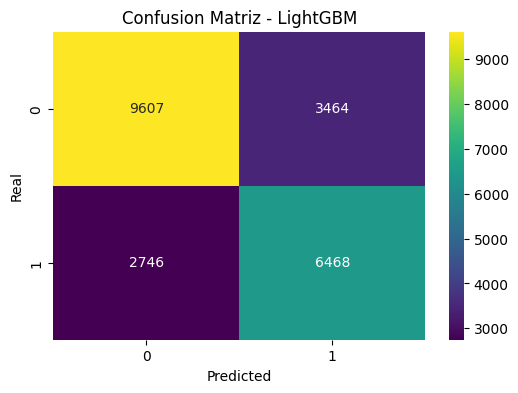

ROC AUC Score:  0.7962607735677865


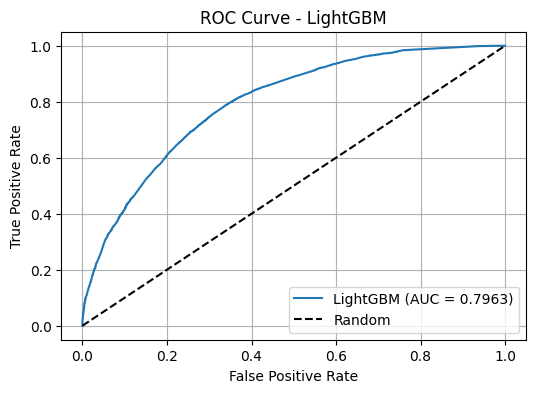

In [20]:
# LightGBM


# Extract the trained model

model = model_results['LightGBM']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'LightGBM (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend()
plt.grid()
plt.show()

# Model 2: XGBoost

Clasification Report:

              precision    recall  f1-score   support

           0       0.77      0.74      0.76     13071
           1       0.65      0.69      0.67      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.71      0.71     22285
weighted avg       0.72      0.72      0.72     22285



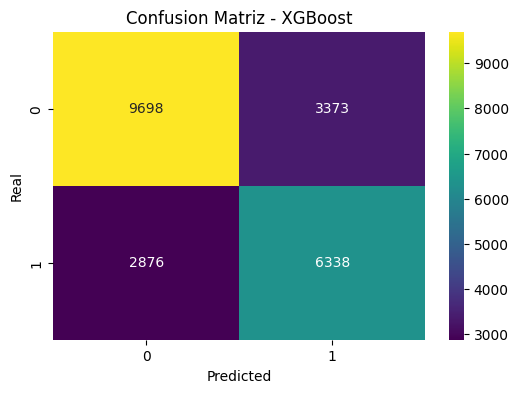

ROC AUC Score:  0.7939154985253021


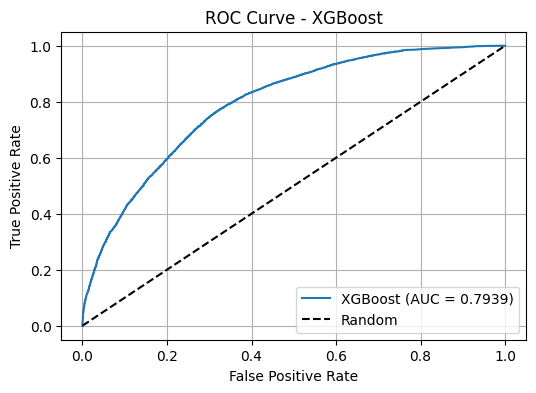

In [21]:
# XGBoost


# Extract the trained model

model = model_results['XGBoost']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'XGBoost (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid()
plt.show()

# Model 3: Stacking

Clasification Report:

              precision    recall  f1-score   support

           0       0.78      0.73      0.75     13071
           1       0.65      0.70      0.67      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.72      0.71     22285
weighted avg       0.72      0.72      0.72     22285



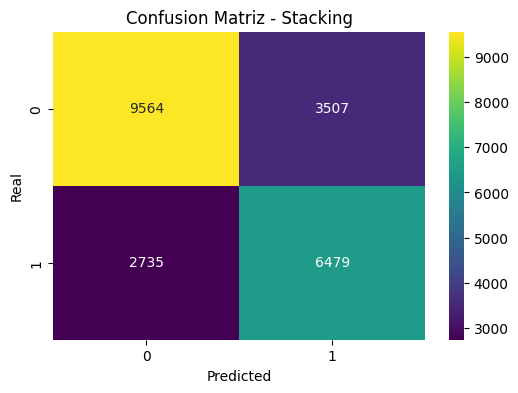

ROC AUC Score:  0.7952925056731699


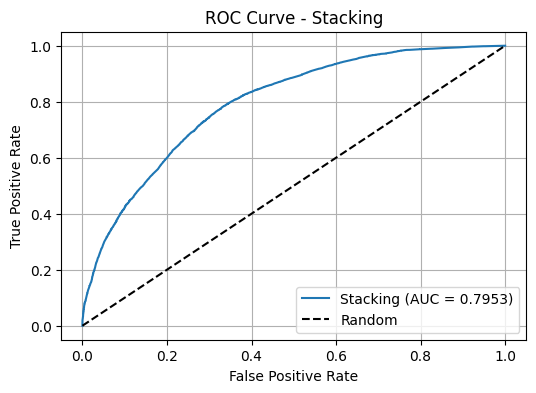

In [22]:
# Stacking


# Extract the trained model

model = model_results['Stacking']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - Stacking')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'Stacking (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking')
plt.legend()
plt.grid()
plt.show()

# Model 4: Random Forest

Clasification Report:

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     13071
           1       0.66      0.65      0.66      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.71      0.71     22285
weighted avg       0.72      0.72      0.72     22285



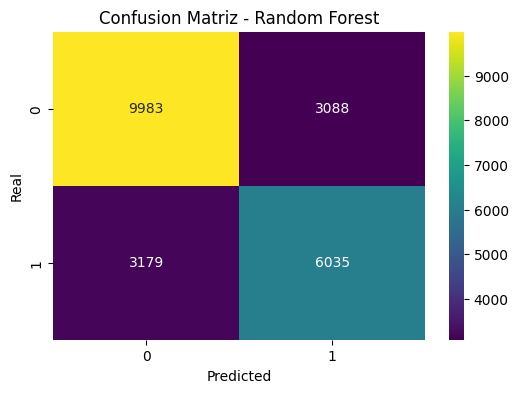

ROC AUC Score:  0.791716251013379


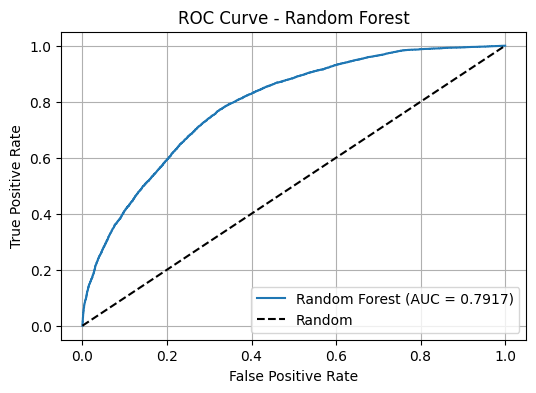

In [23]:
# Random Forest


# Extract the trained model

model = model_results['Random Forest']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'Random Forest (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid()
plt.show()

# Model 5: KNN

Clasification Report:

              precision    recall  f1-score   support

           0       0.68      0.77      0.73     13071
           1       0.60      0.49      0.54      9214

    accuracy                           0.66     22285
   macro avg       0.64      0.63      0.63     22285
weighted avg       0.65      0.66      0.65     22285



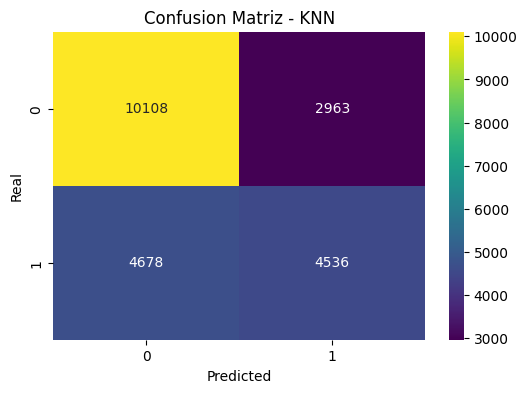

ROC AUC Score:  0.6943618917416138


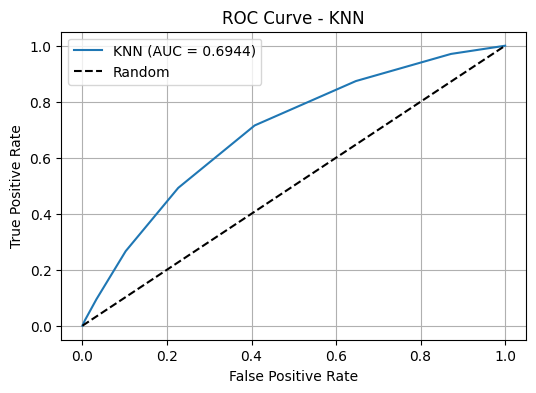

In [24]:
# KNN


# Extract the trained model

model = model_results['KNN']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - KNN')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'KNN (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.grid()
plt.show()

# Model 6: Decision Tree

Clasification Report:

              precision    recall  f1-score   support

           0       0.78      0.73      0.75     13071
           1       0.65      0.71      0.68      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.72      0.72     22285
weighted avg       0.73      0.72      0.72     22285



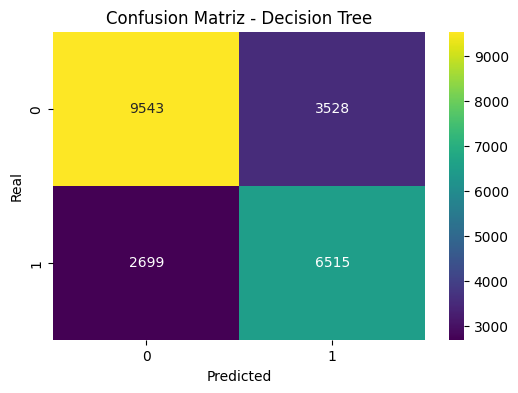

ROC AUC Score:  0.7880684148819913


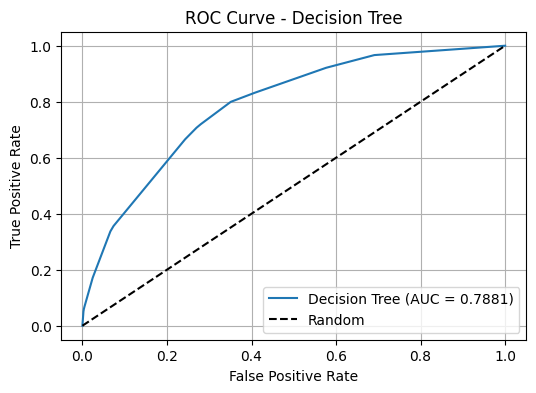

In [25]:
# Decision Tree


# Extract the trained model

model = model_results['Decision Tree']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'Decision Tree (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.grid()
plt.show()

# Model 7: Neuronal Network (MLP)

Clasification Report:

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     13071
           1       0.65      0.68      0.66      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.71      0.71     22285
weighted avg       0.72      0.72      0.72     22285



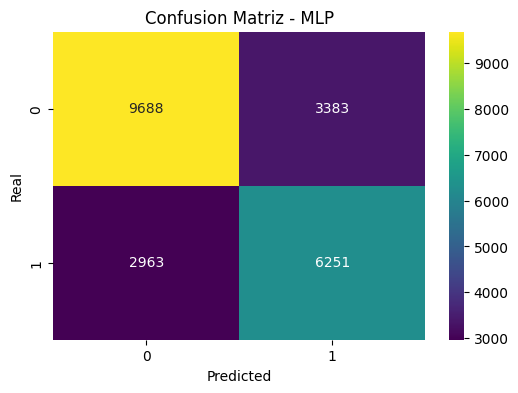

ROC AUC Score:  0.787868176073382


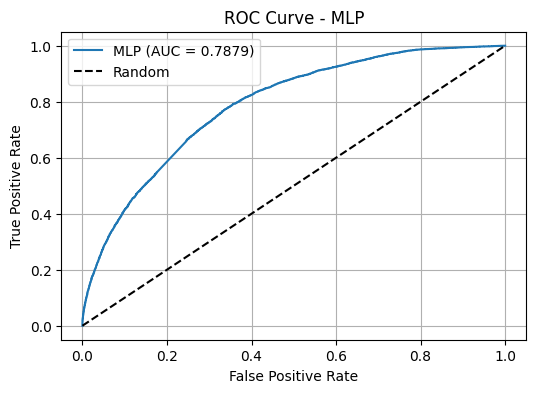

In [26]:
# MLP


# Extract the trained model

model = model_results['MLP']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - MLP')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'MLP (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP')
plt.legend()
plt.grid()
plt.show()

# Model 8: Gradient Boosting

Clasification Report:

              precision    recall  f1-score   support

           0       0.78      0.74      0.76     13071
           1       0.65      0.70      0.67      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.72      0.72     22285
weighted avg       0.73      0.72      0.72     22285



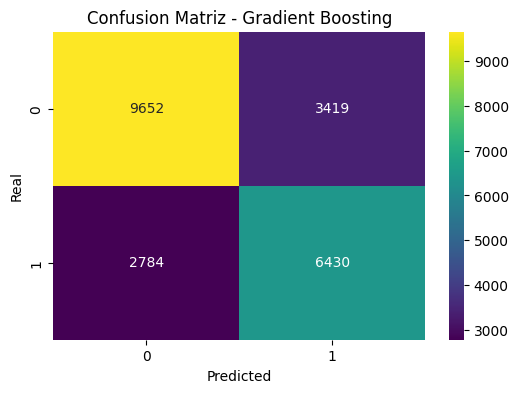

ROC AUC Score:  0.7939484952505225


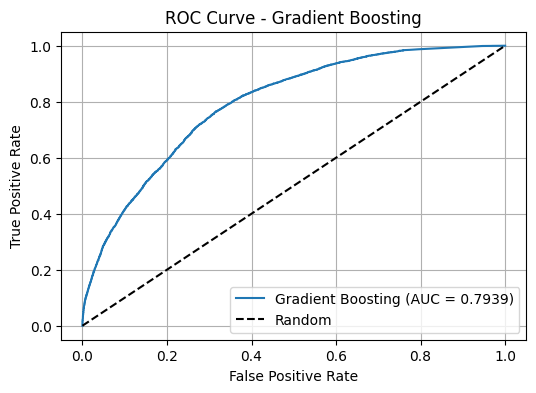

In [27]:
# Gradient Boosting


# Extract the trained model

model = model_results['Gradient Boosting']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'Gradient Boosting (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.grid()
plt.show()

# Model 9: SVM

SVM does not have predict_proba, using decision_function instead
Clasification Report:

              precision    recall  f1-score   support

           0       0.74      0.78      0.76     13071
           1       0.66      0.62      0.64      9214

    accuracy                           0.71     22285
   macro avg       0.70      0.70      0.70     22285
weighted avg       0.71      0.71      0.71     22285



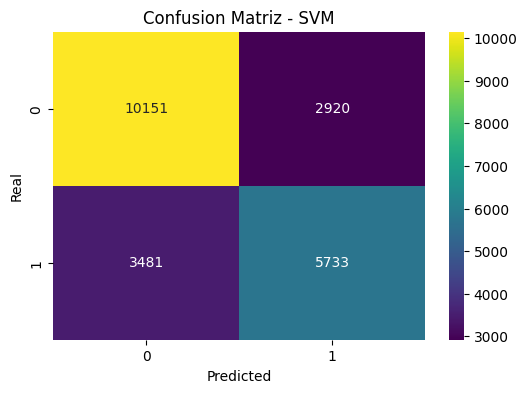

ROC AUC Score:  0.7827793611611473


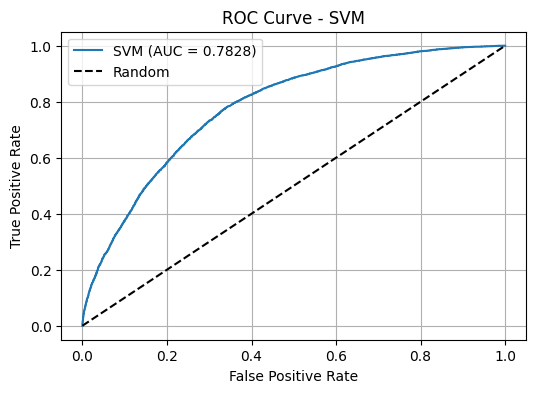

In [30]:
# SVM


# Extract the trained model

model = model_results['SVM']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

try:

    y_scores = model.decision_function(X_test)
    y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    print("SVM does not have predict_proba, using decision_function instead")

except AttributeError as e:

    print(f"Error: {e}. The model may not support probability estimates")
    
    raise


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - SVM')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'SVM (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.grid()
plt.show()

# **Save Models**

In [33]:
# Save the models as joblib files with higher accutacy

joblib.dump(model_results['LightGBM']['model'], 'LightGBM_model.joblib')
joblib.dump(model_results['Decision Tree']['model'], 'DecisionTree_model.joblib')
joblib.dump(model_results['Gradient Boosting']['model'], 'GradientBoosting_model.joblib')

['GradientBoosting_model.joblib']